In [13]:
import os
import numpy as np
import random
import math
import pydicom
import pandas as pd
import shutil
import tensorflow as tf
from functools import partial, update_wrapper
import xml.etree.ElementTree as ET

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

# Retrieving blocks of a numpy array
from skimage.util import view_as_blocks
# Retrieving blocks of a numpy array with given stride sizes
from skimage.util.shape import view_as_windows
from random import randint

from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, concatenate, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Conv2DTranspose, Conv3DTranspose
from keras.layers import Activation, add, multiply, Lambda
from keras.layers import AveragePooling2D, AveragePooling3D, average, UpSampling2D, UpSampling3D, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.initializers import glorot_normal, random_normal, random_uniform
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.losses import binary_crossentropy

In [14]:
from script_libr import *

In [4]:
#helps with gpu overloading errors
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [ ]:
random.seed(42)

In [5]:
basic_path = "Mevislab_Output" #path of the mevislab output files

basic_path2 = "Mevislab_Input" #path of the original file, to be able to acces the .xlm-s

model_logs="/Model_logs/checkpoints/"

model_checkpoint=model_logs+'cyclic_attn_unet_3D_plaque_epoch_{epoch:03d}_valdsc_{val_dif_dsc:03f}.h5'

traintype='Plakk'

base_dir_to_save = "/patches/Plakk/"

base_dir_pred='/predictions/Plakk/'

In [6]:
for direct in [model_logs,bds,base_dir_to_save,bdr,base_dir_pred]:
    #direct=direct.rstrip('/')
    if not os.path.exists(direct):
        os.mkdir(direct)

In [7]:
test_filenames = os.listdir(basic_path)

In [8]:
'/mnt/data/Model_logs/checkpoints2/cyclic_attn_unet_3D_plaque_epoch_017_valdsc_0.660232.h5'

'/mnt/data/Model_logs/checkpoints2/cyclic_attn_unet_3D_plaque_epoch_017_valdsc_0.660232.h5'

In [9]:
arguments = {'alpha': 0.6635482209772863, 'dropout': 0.0022118370088630712, 'gamma': 0.7940638705632237, 'kernel_power': 8, 'learning_rate': 0.00015099469943923109, 'loss_type': 0, 'smooth': 1, 'unet_type': 2}

In [10]:
class arg():
    def __init__(self):
        self.alpha=0.7
        self.gamma=0.75
        self.loss_type=1 #1 for focal tversky
        self.unet_type=0 #1 for attn unet
        self.smooth=1
        self.learning_rate=0.0001

In [11]:
args=arg()
args.loss_type=arguments['loss_type']
args.unet_type=arguments['unet_type']
args.smooth=arguments['smooth']
args.alpha=arguments['alpha']
args.gamma=arguments['gamma']
args.learning_rate=arguments['learning_rate']
args.dropout=arguments['dropout']
args.kernel_power=arguments['kernel_power']

{'alpha': 0.6635482209772863, 'dropout': 0.0022118370088630712, 'gamma': 0.7940638705632237, 'kernel_power': 8, 'learning_rate': 0.00015099469943923109, 'loss_type': 0, 'smooth': 1, 'unet_type': 2}


In [12]:
model = tiny_attn_unet3D(Adam(learning_rate=args.learning_rate), (24,32,32,1),args)
model.load_weights('model_internal_dataset.h5')

In [14]:
all_files = os.listdir(basic_path)
all_pairs = get_pairs(all_files)

In [187]:
param_dict = {'ID_tuple_list': all_pairs,
              'dir_to_save': base_dir_to_save,
              'train_val_test_split': [0.6, 0.2, 0.2],
              'patch_shape': [64,64,24],
              'stride_size': [64,64,12],
              'basic_path': basic_path,
              'basic_path2': basic_path2,
              'truncate': True,
              "plaques_only": False,
              'val_patients': None, 
              'test_patients': None
              }

save_all_patch(**param_dict)

835it [00:00, 1635798.15it/s]
835it [00:13, 59.84it/s]


['PA00095',
 'PA00240',
 'PA00171',
 'PA00147',
 'PA00199',
 'PA00140',
 'PA00192',
 'PA00162',
 'PA00156',
 'PA00086',
 'PA00160',
 'PA00139',
 'PA00151',
 'PA00172',
 'PA00214',
 'PA00091',
 'PA00130',
 'PA00167',
 'PA00168',
 'PA00186',
 'PA00150',
 'PA00215',
 'PA00181',
 'PA00193',
 'PA00131',
 'PA00027',
 'PA00032']

In [36]:
path_to_train_images = os.path.join(base_dir_to_save,"train","images")
path_to_train_masks_1 = os.path.join(base_dir_to_save,"train","masks_1")
path_to_train_masks_2 = os.path.join(base_dir_to_save,"train","masks_2")
path_to_train_plaques = os.path.join(base_dir_to_save,"train","plaques")

path_to_val_images = os.path.join(base_dir_to_save,"val","images")
path_to_val_masks_1 = os.path.join(base_dir_to_save,"val","masks_1")
path_to_val_masks_2 = os.path.join(base_dir_to_save,"val","masks_2")
path_to_val_plaques = os.path.join(base_dir_to_save,"val","plaques")

In [37]:
train_filenames = os.listdir(path_to_train_images)
val_filenames = os.listdir(path_to_val_images)

In [39]:
train_images = np.zeros(shape = (len(train_filenames), 24, 32, 32, 1), dtype='float32')
train_masks_1 = np.zeros(shape = (len(train_filenames), 24, 32, 32, 1), dtype='uint8')
train_masks_2 = np.zeros(shape = (len(train_filenames), 24, 32, 32, 1), dtype='uint8')
train_dif = np.zeros(shape = (len(train_filenames), 24, 32, 32, 1), dtype='uint8')

val_images = np.zeros(shape = (len(val_filenames), 24, 32, 32, 1), dtype='float32')
val_masks_1 = np.zeros(shape = (len(val_filenames), 24, 32, 32, 1), dtype='uint8')
val_masks_2 = np.zeros(shape = (len(val_filenames), 24, 32, 32, 1), dtype='uint8')
val_dif  = np.zeros(shape = (len(val_filenames), 24, 32, 32, 1), dtype='uint8')

In [40]:
for index, filename in tqdm(enumerate(train_filenames)):
    loaded_image = np.load(os.path.join(path_to_train_images, filename))
    loaded_mask_1 = np.load(os.path.join(path_to_train_masks_1, filename))
    loaded_mask_2 = np.load(os.path.join(path_to_train_masks_2, filename))
    loaded_plaque = np.load(os.path.join(path_to_train_plaques, filename))
    
    train_images[index, :, :, :, 0] = loaded_image
    train_masks_1[index, :, :, :, 0] = loaded_mask_1
    train_masks_2[index, :, :, :, 0] = loaded_mask_2
    train_dif[index, :, :, :, 0] = loaded_plaque
    
for index, filename in tqdm(enumerate(val_filenames)):
    loaded_image = np.load(os.path.join(path_to_val_images, filename))
    loaded_mask_1 = np.load(os.path.join(path_to_val_masks_1, filename))
    loaded_mask_2 = np.load(os.path.join(path_to_val_masks_2, filename))
    loaded_plaque = np.load(os.path.join(path_to_val_plaques, filename))
    
    val_images[index, :, :, :, 0] = loaded_image
    val_masks_1[index, :, :, :, 0] = loaded_mask_1
    val_masks_2[index, :, :, :, 0] = loaded_mask_2
    val_dif[index, :, :, :, 0] = loaded_plaque

629it [00:13, 45.17it/s]
130it [00:02, 44.71it/s]


In [44]:
epoch_number = 100
batch_number = 8
model_checkpoint=model_logs+'cyclic_attn_unet_3D_plaque_epoch_{epoch:03d}_valdsc_{val_dif_dsc:03f}.h5'
checkpoint = ModelCheckpoint(model_checkpoint,
                             verbose=1,
                             monitor='val_dif_dsc',
                             save_best_only=True,
                             mode='max')

LR=args.learning_rate
cyclic_lr = CyclicLR(base_lr=LR, max_lr=LR*6, step_size=2000.0)
history_attn_unet = model.fit(train_images/512,
                                        [train_masks_1, train_masks_2, train_dif],
                                        epochs = epoch_number,
                                        batch_size=batch_number,
                                        verbose=2,
                                        shuffle=True,
                                        validation_data=(val_images/512, [val_masks_1, val_masks_2, val_dif]),
                                        callbacks=[checkpoint,cyclic_lr])

Train on 629 samples, validate on 130 samples
Epoch 1/100
 - 7s - loss: 0.1540 - mask_1_loss: 0.0767 - mask_2_loss: 0.0498 - dif_loss: 0.1771 - mask_1_dsc: 0.9233 - mask_2_dsc: 0.9502 - dif_dsc: 0.8229 - dif_tp: 0.8427 - dif_tn: 0.9817 - val_loss: 0.2406 - val_mask_1_loss: 0.1135 - val_mask_2_loss: 0.0832 - val_dif_loss: 0.2754 - val_mask_1_dsc: 0.8865 - val_mask_2_dsc: 0.9168 - val_dif_dsc: 0.7246 - val_dif_tp: 0.7197 - val_dif_tn: 0.9763

Epoch 00001: val_dif_dsc improved from -inf to 0.72461, saving model to /mnt/data/Model_logs/checkpointsNRS2/cyclic_attn_unet_3D_plaque_epoch_001_valdsc_0.724614.h5
Epoch 2/100
 - 4s - loss: 0.1506 - mask_1_loss: 0.0753 - mask_2_loss: 0.0485 - dif_loss: 0.1727 - mask_1_dsc: 0.9247 - mask_2_dsc: 0.9515 - dif_dsc: 0.8273 - dif_tp: 0.8471 - dif_tn: 0.9823 - val_loss: 0.2520 - val_mask_1_loss: 0.1115 - val_mask_2_loss: 0.0875 - val_dif_loss: 0.2889 - val_mask_1_dsc: 0.8885 - val_mask_2_dsc: 0.9125 - val_dif_dsc: 0.7111 - val_dif_tp: 0.6773 - val_dif_tn:


Epoch 00018: val_dif_dsc did not improve from 0.72723
Epoch 19/100
 - 4s - loss: 0.1260 - mask_1_loss: 0.0614 - mask_2_loss: 0.0421 - dif_loss: 0.1447 - mask_1_dsc: 0.9386 - mask_2_dsc: 0.9579 - dif_dsc: 0.8553 - dif_tp: 0.8723 - dif_tn: 0.9852 - val_loss: 0.2482 - val_mask_1_loss: 0.1145 - val_mask_2_loss: 0.0861 - val_dif_loss: 0.2839 - val_mask_1_dsc: 0.8855 - val_mask_2_dsc: 0.9139 - val_dif_dsc: 0.7161 - val_dif_tp: 0.7063 - val_dif_tn: 0.9761

Epoch 00019: val_dif_dsc did not improve from 0.72723
Epoch 20/100
 - 4s - loss: 0.1324 - mask_1_loss: 0.0637 - mask_2_loss: 0.0445 - dif_loss: 0.1521 - mask_1_dsc: 0.9363 - mask_2_dsc: 0.9555 - dif_dsc: 0.8479 - dif_tp: 0.8658 - dif_tn: 0.9843 - val_loss: 0.2603 - val_mask_1_loss: 0.1189 - val_mask_2_loss: 0.0880 - val_dif_loss: 0.2995 - val_mask_1_dsc: 0.8811 - val_mask_2_dsc: 0.9120 - val_dif_dsc: 0.7005 - val_dif_tp: 0.6742 - val_dif_tn: 0.9777

Epoch 00020: val_dif_dsc did not improve from 0.72723
Epoch 21/100
 - 4s - loss: 0.1293 - m

 - 4s - loss: 0.1017 - mask_1_loss: 0.0485 - mask_2_loss: 0.0355 - dif_loss: 0.1166 - mask_1_dsc: 0.9515 - mask_2_dsc: 0.9645 - dif_dsc: 0.8834 - dif_tp: 0.8935 - dif_tn: 0.9886 - val_loss: 0.2533 - val_mask_1_loss: 0.1145 - val_mask_2_loss: 0.0887 - val_dif_loss: 0.2898 - val_mask_1_dsc: 0.8855 - val_mask_2_dsc: 0.9113 - val_dif_dsc: 0.7102 - val_dif_tp: 0.6992 - val_dif_tn: 0.9755

Epoch 00037: val_dif_dsc did not improve from 0.72723
Epoch 38/100
 - 4s - loss: 0.0986 - mask_1_loss: 0.0478 - mask_2_loss: 0.0340 - dif_loss: 0.1131 - mask_1_dsc: 0.9522 - mask_2_dsc: 0.9660 - dif_dsc: 0.8869 - dif_tp: 0.8972 - dif_tn: 0.9889 - val_loss: 0.2564 - val_mask_1_loss: 0.1144 - val_mask_2_loss: 0.0865 - val_dif_loss: 0.2943 - val_mask_1_dsc: 0.8856 - val_mask_2_dsc: 0.9135 - val_dif_dsc: 0.7057 - val_dif_tp: 0.6715 - val_dif_tn: 0.9794

Epoch 00038: val_dif_dsc did not improve from 0.72723
Epoch 39/100
 - 4s - loss: 0.0970 - mask_1_loss: 0.0465 - mask_2_loss: 0.0334 - dif_loss: 0.1114 - mask_1


Epoch 00055: val_dif_dsc did not improve from 0.72723
Epoch 56/100
 - 4s - loss: 0.0798 - mask_1_loss: 0.0390 - mask_2_loss: 0.0281 - dif_loss: 0.0912 - mask_1_dsc: 0.9610 - mask_2_dsc: 0.9719 - dif_dsc: 0.9088 - dif_tp: 0.9158 - dif_tn: 0.9912 - val_loss: 0.2575 - val_mask_1_loss: 0.1144 - val_mask_2_loss: 0.0861 - val_dif_loss: 0.2958 - val_mask_1_dsc: 0.8856 - val_mask_2_dsc: 0.9139 - val_dif_dsc: 0.7042 - val_dif_tp: 0.6660 - val_dif_tn: 0.9803

Epoch 00056: val_dif_dsc did not improve from 0.72723
Epoch 57/100
 - 4s - loss: 0.0803 - mask_1_loss: 0.0388 - mask_2_loss: 0.0284 - dif_loss: 0.0922 - mask_1_dsc: 0.9612 - mask_2_dsc: 0.9716 - dif_dsc: 0.9078 - dif_tp: 0.9142 - dif_tn: 0.9913 - val_loss: 0.2537 - val_mask_1_loss: 0.1151 - val_mask_2_loss: 0.0851 - val_dif_loss: 0.2910 - val_mask_1_dsc: 0.8849 - val_mask_2_dsc: 0.9149 - val_dif_dsc: 0.7090 - val_dif_tp: 0.6829 - val_dif_tn: 0.9784

Epoch 00057: val_dif_dsc did not improve from 0.72723
Epoch 58/100
 - 4s - loss: 0.0823 - m

 - 4s - loss: 0.0895 - mask_1_loss: 0.0423 - mask_2_loss: 0.0311 - dif_loss: 0.1029 - mask_1_dsc: 0.9577 - mask_2_dsc: 0.9689 - dif_dsc: 0.8971 - dif_tp: 0.9045 - dif_tn: 0.9903 - val_loss: 0.2525 - val_mask_1_loss: 0.1174 - val_mask_2_loss: 0.0875 - val_dif_loss: 0.2907 - val_mask_1_dsc: 0.8826 - val_mask_2_dsc: 0.9125 - val_dif_dsc: 0.7093 - val_dif_tp: 0.7076 - val_dif_tn: 0.9745

Epoch 00074: val_dif_dsc did not improve from 0.72723
Epoch 75/100
 - 4s - loss: 0.0849 - mask_1_loss: 0.0401 - mask_2_loss: 0.0298 - dif_loss: 0.0974 - mask_1_dsc: 0.9599 - mask_2_dsc: 0.9702 - dif_dsc: 0.9026 - dif_tp: 0.9092 - dif_tn: 0.9907 - val_loss: 0.2564 - val_mask_1_loss: 0.1194 - val_mask_2_loss: 0.0879 - val_dif_loss: 0.2968 - val_mask_1_dsc: 0.8806 - val_mask_2_dsc: 0.9121 - val_dif_dsc: 0.7032 - val_dif_tp: 0.6842 - val_dif_tn: 0.9773

Epoch 00075: val_dif_dsc did not improve from 0.72723
Epoch 76/100
 - 4s - loss: 0.0861 - mask_1_loss: 0.0406 - mask_2_loss: 0.0302 - dif_loss: 0.0989 - mask_1


Epoch 00092: val_dif_dsc did not improve from 0.72723
Epoch 93/100
 - 4s - loss: 0.0641 - mask_1_loss: 0.0307 - mask_2_loss: 0.0236 - dif_loss: 0.0735 - mask_1_dsc: 0.9693 - mask_2_dsc: 0.9764 - dif_dsc: 0.9265 - dif_tp: 0.9307 - dif_tn: 0.9932 - val_loss: 0.2535 - val_mask_1_loss: 0.1144 - val_mask_2_loss: 0.0865 - val_dif_loss: 0.2912 - val_mask_1_dsc: 0.8856 - val_mask_2_dsc: 0.9135 - val_dif_dsc: 0.7088 - val_dif_tp: 0.6883 - val_dif_tn: 0.9776

Epoch 00093: val_dif_dsc did not improve from 0.72723
Epoch 94/100
 - 4s - loss: 0.0625 - mask_1_loss: 0.0297 - mask_2_loss: 0.0229 - dif_loss: 0.0720 - mask_1_dsc: 0.9703 - mask_2_dsc: 0.9771 - dif_dsc: 0.9280 - dif_tp: 0.9313 - dif_tn: 0.9934 - val_loss: 0.2578 - val_mask_1_loss: 0.1149 - val_mask_2_loss: 0.0863 - val_dif_loss: 0.2962 - val_mask_1_dsc: 0.8851 - val_mask_2_dsc: 0.9137 - val_dif_dsc: 0.7038 - val_dif_tp: 0.6724 - val_dif_tn: 0.9788

Epoch 00094: val_dif_dsc did not improve from 0.72723
Epoch 95/100
 - 4s - loss: 0.0615 - m

In [42]:
#model = tiny_attn_unet3D(Adam(learning_rate=args.learning_rate), (24,32,32,1),args)
#model.load_weights('') #can load the created best model here

In [177]:
def visualize_automata_vs_prediction_nf(image_array, diff_array, aut_array, pred_array, opacity=0.8, name = "",strictness=9,Two_Dim=True):
    ax, plots = plt.subplots(2, 3, figsize=(25, 10))
    ax.suptitle(name)
    plots[0,0].axis('off')
    plots[0,0].imshow(diff_array, cmap=plt.cm.bone)
    plots[0,0].set_title('Doctor')
    plots[0,1].axis('off')
    plots[0,1].imshow(aut_array, cmap=plt.cm.bone)
    plots[0,1].set_title('Automata')
    plots[0,2].axis('off')
    plots[0,2].imshow(pred_array, cmap=plt.cm.bone)
    plots[0,2].set_title('ML')
    
    plots[1,0].axis('off')
    plots[1,0].imshow(superimpose_mask2(image_array, diff_array, opacity=opacity))
    plots[1,1].axis('off')
    plots[1,1].imshow(superimpose_mask2(image_array, aut_array, opacity=opacity))
    plots[1,2].axis('off')
    plots[1,2].imshow(superimpose_mask2(image_array, pred_array, opacity=opacity))

    plt.show()

In [161]:
def one_vessel(image_name,L):    
    '''
    image_name is is the name of the image to be visualized
    L is the slice of the image which is to be visualized
    '''
    image_path = os.path.join(basic_path, image_name)

    image_dicom=pydicom.dcmread(image_path)
    images = image_dicom.pixel_array 

    mask_1_path = os.path.join(basic_path, image_name[:-13]+"Contour1.dcm")
    mask_2_path = os.path.join(basic_path, image_name[:-13]+"Contour2.dcm")

    mask_1=mask_from_dicom(mask_1_path)
    mask_1cut=np.zeros(mask_1.shape).astype('int')
    mask_1cut[:,16:48,16:48]=mask_1[:,16:48,16:48]

    mask_2=mask_from_dicom(mask_2_path)
    mask_2cut=np.zeros(mask_2.shape).astype('int')
    mask_2cut[:,16:48,16:48]=mask_2[:,16:48,16:48]

    masks[0,1,j] = mask_1cut
    masks[0,2,j] = mask_2cut
    masks[0,0,j] = masks[0,2,j]-masks[0,1,j]                    
        
    masks[0,0,j+1] = full_ct_model_evaluation(image = images, model = model, z_stride = 12, which_prediction=2)
    masks[0,1,j+1] = full_ct_model_evaluation(image = images, model = model, z_stride = 12, which_prediction=0)
    masks[0,2,j+1] = full_ct_model_evaluation(image = images, model = model, z_stride = 12, which_prediction=1)  

    visualize_automata_vs_prediction_nf(images[L],masks[0,0,1][L],masks[0,0,0][L],masks[0,0,2][L])
     
    return masks

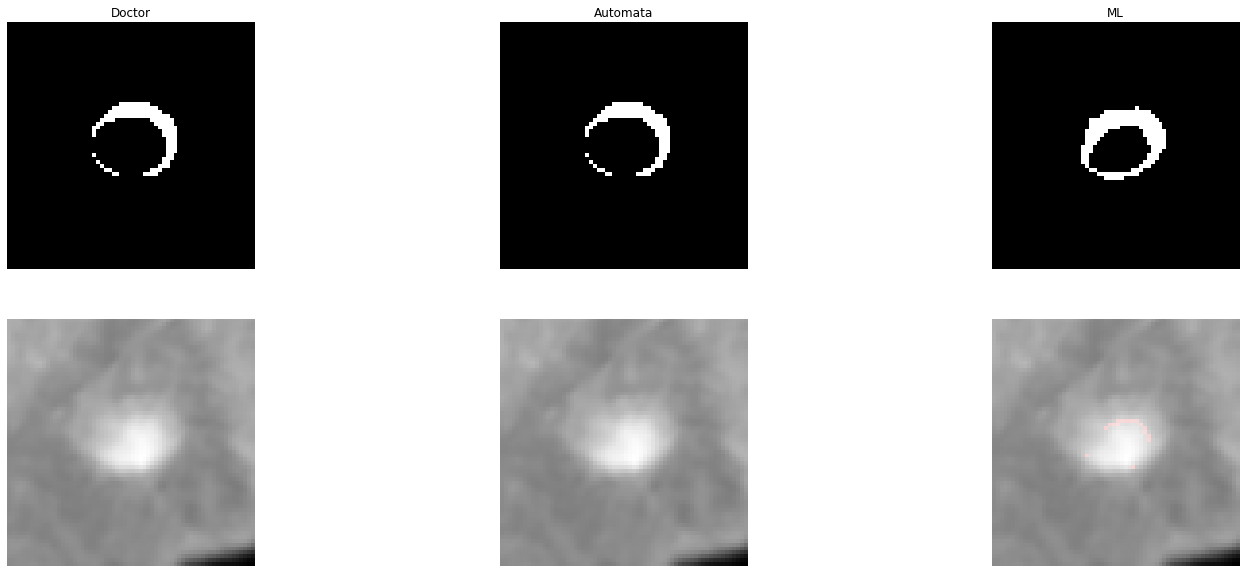

,Patient,trainvaltest,volumeAUTOMATA,volumeAUTOMATA-DenseCalcium,volumeAUTOMATA-Fibrous,volumeAUTOMATA-FibrousFatty,volumeAUTOMATA-NecroticCore,volumeAUTOMATA-NonCalcified,inner_dsc-AUTOMATA-AUTOMATA,inner_dsc-AUTOMATA-KM,inner_dsc-AUTOMATA-Prediciton,outer_dsc-AUTOMATA-AUTOMATA,outer_dsc-AUTOMATA-KM,outer_dsc-AUTOMATA-Prediciton,mask_dsc-AUTOMATA-AUTOMATA,mask_dsc-AUTOMATA-KM,mask_dsc-AUTOMATA-Prediciton,volumeKM,volumeKM-DenseCalcium,volumeKM-Fibrous,volumeKM-FibrousFatty,volumeKM-NecroticCore,volumeKM-NonCalcified,inner_dsc-KM-AUTOMATA,inner_dsc-KM-KM,inner_dsc-KM-Prediciton,outer_dsc-KM-AUTOMATA,outer_dsc-KM-KM,outer_dsc-KM-Prediciton,mask_dsc-KM-AUTOMATA,mask_dsc-KM-KM,mask_dsc-KM-Prediciton,volumePrediciton,volumePrediciton-DenseCalcium,volumePrediciton-Fibrous,volumePrediciton-FibrousFatty,volumePrediciton-NecroticCore,volumePrediciton-NonCalcified,inner_dsc-Prediciton-AUTOMATA,inner_dsc-Prediciton-KM,inner_dsc-Prediciton-Prediciton,outer_dsc-Prediciton-AUTOMATA,outer_dsc-Prediciton-KM,outer_dsc-Prediciton-Prediciton,mask_dsc-Prediciton-AUTOMATA,mask_dsc-Prediciton-KM,mask_dsc-Prediciton-Prediciton,volumeAUTOMATA_filter,volumeAUTOMATA_filter-DenseCalcium,volumeAUTOMATA_filter-Fibrous,volumeAUTOMATA_filter-FibrousFatty,volumeAUTOMATA_filter-NecroticCore,volumeAUTOMATA_filter-NonCalcified,inner_dsc_filter-AUTOMATA-AUTOMATA,inner_dsc_filter-AUTOMATA-KM,inner_dsc_filter-AUTOMATA-Prediciton,outer_dsc_filter-AUTOMATA-AUTOMATA,outer_dsc_filter-AUTOMATA-KM,outer_dsc_filter-AUTOMATA-Prediciton,mask_dsc_filter-AUTOMATA-AUTOMATA,mask_dsc_filter-AUTOMATA-KM,mask_dsc_filter-AUTOMATA-Prediciton,volumeKM_filter,volumeKM_filter-DenseCalcium,volumeKM_filter-Fibrous,volumeKM_filter-FibrousFatty,volumeKM_filter-NecroticCore,volumeKM_filter-NonCalcified,inner_dsc_filter-KM-AUTOMATA,inner_dsc_filter-KM-KM,inner_dsc_filter-KM-Prediciton,outer_dsc_filter-KM-AUTOMATA,outer_dsc_filter-KM-KM,outer_dsc_filter-KM-Prediciton,mask_dsc_filter-KM-AUTOMATA,mask_dsc_filter-KM-KM,mask_dsc_filter-KM-Prediciton,volumePrediciton_filter,volumePrediciton_filter-DenseCalcium,volumePrediciton_filter-Fibrous,volumePrediciton_filter-FibrousFatty,volumePrediciton_filter-NecroticCore,volumePrediciton_filter-NonCalcified,inner_dsc_filter-Prediciton-AUTOMATA,inner_dsc_filter-Prediciton-KM,inner_dsc_filter-Prediciton-Prediciton,outer_dsc_filter-Prediciton-AUTOMATA,outer_dsc_filter-Prediciton-KM,outer_dsc_filter-Prediciton-Prediciton,mask_dsc_filter-Prediciton-AUTOMATA,mask_dsc_filter-Prediciton-KM,mask_dsc_filter-Prediciton-Prediciton
0,PA00002,test,147.875,12.5,113.90625,13.9375,6.15625,135.03125,1.0,0.974962,0.903763,1.0,0.792271,0.865214,1.0,0.484896,0.495719,411.78125,16.625,158.34375,55.75,153.875,394.71875,0.974962,1.0,0.906309,0.792271,1.0,0.856382,0.484896,1.0,0.640246,330.21875,24.5625,179.71875,36.5,82.3125,305.25,0.903763,0.906309,1.0,0.865214,0.856382,1.0,0.495719,0.640246,1.0,14.625,2.15625,12.15625,0.25,0.0,12.40625,1.0,0.973877,0.90455,1.0,0.785098,0.864134,1.0,0.075531,0.114613,303.125,9.8125,76.78125,43.15625,147.9375,293.0625,0.973877,1.0,0.907257,0.785098,1.0,0.850763,0.075531,1.0,0.52613,192.59375,15.75,79.375,20.4375,71.46875,176.53125,0.90455,0.907257,1.0,0.864134,0.850763,1.0,0.114613,0.52613,1.0


In [128]:
one_vessel(0,10)